In [ ]:
# base
import pandas as pd 
import geopandas as gpd
import numpy as np
import zipfile
import os
import datetime
import random

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# ML
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import pmdarima
import numba
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.datatypes import check_raise, convert_to

# function
import famDataset
# force reload to not restart jupyter each time
from importlib import reload
reload(famDataset)

<module 'famDataset' from '/home/tibo/Documents/Github/projet-fil-rouge-TiboGar-1/data/famDataset.py'>

In [2]:
# ----------------------------- #
# User input
# ----------------------------- #

# Especes
espece='Blé tendre'
espece='Maïs'

# ----------------------------- #
# Init
# ----------------------------- #
fam = famDataset.famDataset(root_dir=os.getcwd())
fam.load_transformed_data(convert_attributes = True, drop_attributes = False, pivot_to_long = False)
fam.load_geometry_data()

fam_data = fam.transformed_data.copy()

fam_data

Raw data loading complete
Raw data processed in transformed_data
Geom data loading complete


,ESPECES,DEP,DATE,CAMPAGNE,TOTAL_COLLECTE,STOCKS,STOCKS_DEPOTS,ENTREE_DEPOT,SORTIE_DEPOT,REPRISE_DEPOT,CORRECT_COLLECTE,ENTREE,LAG_DIFF,SORTIE
0,Avoine,01,2000-07-01,2000/01,2245.9,2642.7,151.0,162.2,0.0,1.4,0.0,2408.1,0.0,-2247.3
1,Avoine,01,2000-08-01,2000/01,461.6,2886.8,198.4,96.3,0.0,38.4,0.0,557.9,244.1,-255.9
2,Avoine,01,2000-09-01,2000/01,76.8,2495.0,193.2,18.6,0.0,25.5,0.0,95.4,-391.8,-494.1
3,Avoine,01,2000-10-01,2000/01,21.7,2196.9,191.1,0.0,-7.7,3.5,0.0,21.7,-298.1,-315.6
4,Avoine,01,2000-11-01,2000/01,28.4,1976.2,183.9,11.4,0.0,16.2,0.0,39.8,-220.7,-265.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466939,Triticale,2A,2025-06-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466940,Triticale,2A,2025-07-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466941,Triticale,2A,2025-08-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466942,Triticale,2A,2025-09-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Departement clustering

# Plan du clustering

- I Méthode de représentation
- II Mesure de distance
- III Algo de clustering
- IV Evaluation de perf

In [3]:
# ----------------------------- #
# Add some attribute
# ----------------------------- #

# compute total stock
fam_data['T_STOCKS'] = fam_data['STOCKS']+fam_data['STOCKS_DEPOTS']


# compute SORTIE divided by max stocks

# compute 12-row rolling max of STOCKS within each ESPECES+DEP group
# fam_data['MAX_STOCKS'] = fam_data.groupby(['ESPECES','DEP','CAMPAGNE'])['STOCKS'].rolling(12, min_periods=1).max().reset_index(level=[0,1,2], drop=True)
fam_data['MAX_STOCKS'] = fam_data.groupby(['ESPECES','DEP'])['T_STOCKS'].rolling(12, min_periods=1).max().reset_index(level=[0,1], drop=True)

fam_data['SORTIE_ON_MAX'] = fam_data['SORTIE'] / fam_data['MAX_STOCKS']

# When Stocks is null, set the variable to null
fam_data.loc[fam_data['MAX_STOCKS'] == 0,'SORTIE_ON_MAX'] = 0


/tmp/ipykernel_144165/3890590375.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)


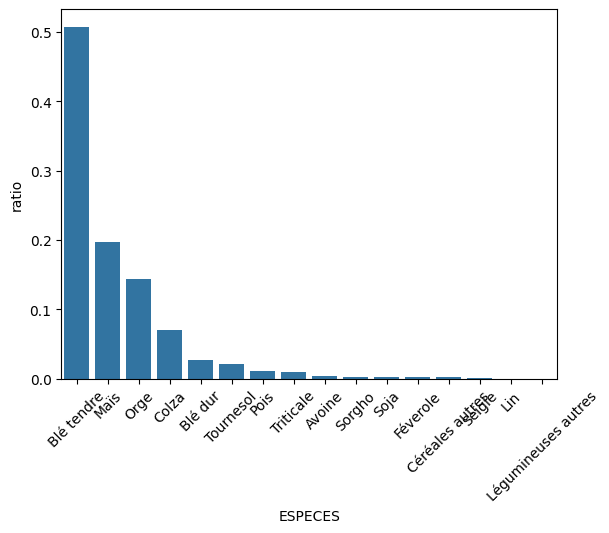

                        ratio  cum_ratio
ESPECES                                 
Blé tendre           0.507272   0.507272
Maïs                 0.196451   0.703723
Orge                 0.143357   0.847080
Colza                0.069548   0.916629
Blé dur              0.026474   0.943103
Tournesol            0.021362   0.964465
Pois                 0.010793   0.975258
Triticale            0.009522   0.984780
Avoine               0.003327   0.988107
Sorgho               0.003023   0.991130
Soja                 0.002781   0.993911
Féverole             0.002751   0.996662
Céréales autres      0.001977   0.998639
Seigle               0.000895   0.999534
Lin                  0.000321   0.999855
Légumineuses autres  0.000145   1.000000


In [4]:
# ---------------------- #
# Species selection

df = fam_data[['ESPECES','DEP','DATE','ENTREE','T_STOCKS','SORTIE','SORTIE_ON_MAX']].copy()

graph_df = df.groupby('ESPECES').sum('ENTREE').sort_values('ENTREE',ascending=False)
graph_df['ratio'] = graph_df['ENTREE']/sum(graph_df['ENTREE'])
graph_df['cum_ratio'] = graph_df['ratio'].cumsum()


g = sns.barplot(graph_df,y = 'ratio', x = 'ESPECES')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.show(g)

print(graph_df[['ratio','cum_ratio']])

In [5]:
# 94% of the French production is made by 5 species. We only select them.
select_species = graph_df.loc[graph_df['cum_ratio'] < 0.92].index


In [6]:
# ----------------------------- #
# Preprocessing 

# X is the data used in the clustering 
df = fam_data.loc[fam_data['ESPECES'].isin(select_species), ['ESPECES','DEP','DATE','ENTREE','T_STOCKS','SORTIE','SORTIE_ON_MAX']]

X = df.groupby(['ESPECES','DEP']).median().reset_index()[['ESPECES','DEP','ENTREE','T_STOCKS','SORTIE','SORTIE_ON_MAX']]
X.rename(columns={'ENTREE':'mENTREE','T_STOCKS':'mSTOCKS','SORTIE':'mSORTIE','SORTIE_ON_MAX':'mSORTIE_ON_MAX'}, inplace=True)

## Geographique - Long / Lat distance from france center
geom_data = fam.geom_data.copy()

france_center = geom_data.loc[geom_data['code_insee'] == '03','centroid']

geom_data['long'] = fam.geom_data['centroid'].x.values- france_center.x.values
geom_data['lat'] = fam.geom_data['centroid'].y.values- france_center.y.values

# merge 
geom_data.rename(columns={'code_insee':'DEP'},inplace=True)
X = pd.merge(X, geom_data[['long','lat','DEP']], on=  'DEP')

X

,ESPECES,DEP,mENTREE,mSTOCKS,mSORTIE,mSORTIE_ON_MAX,long,lat
0,Blé tendre,01,4888.35,88612.85,-14847.55,-0.088597,2.161115,-0.293865
1,Blé tendre,02,89088.60,456799.45,-119078.85,-0.152503,0.372102,3.167391
2,Blé tendre,03,25310.05,97358.70,-22072.10,-0.141314,0.000000,0.000000
3,Blé tendre,04,60.05,2632.50,-481.95,-0.094942,3.057247,-2.287452
4,Blé tendre,05,85.50,3716.10,-620.15,-0.094665,3.077914,-1.729593
...,...,...,...,...,...,...,...,...
379,Orge,91,5309.60,45692.45,-7985.95,-0.105962,-0.944097,2.129002
380,Orge,92,0.00,0.00,0.00,0.000000,-0.941663,2.454072
381,Orge,93,0.00,0.00,0.00,0.000000,-0.709114,2.523935
382,Orge,94,0.00,0.00,0.00,0.000000,-0.718334,2.383780


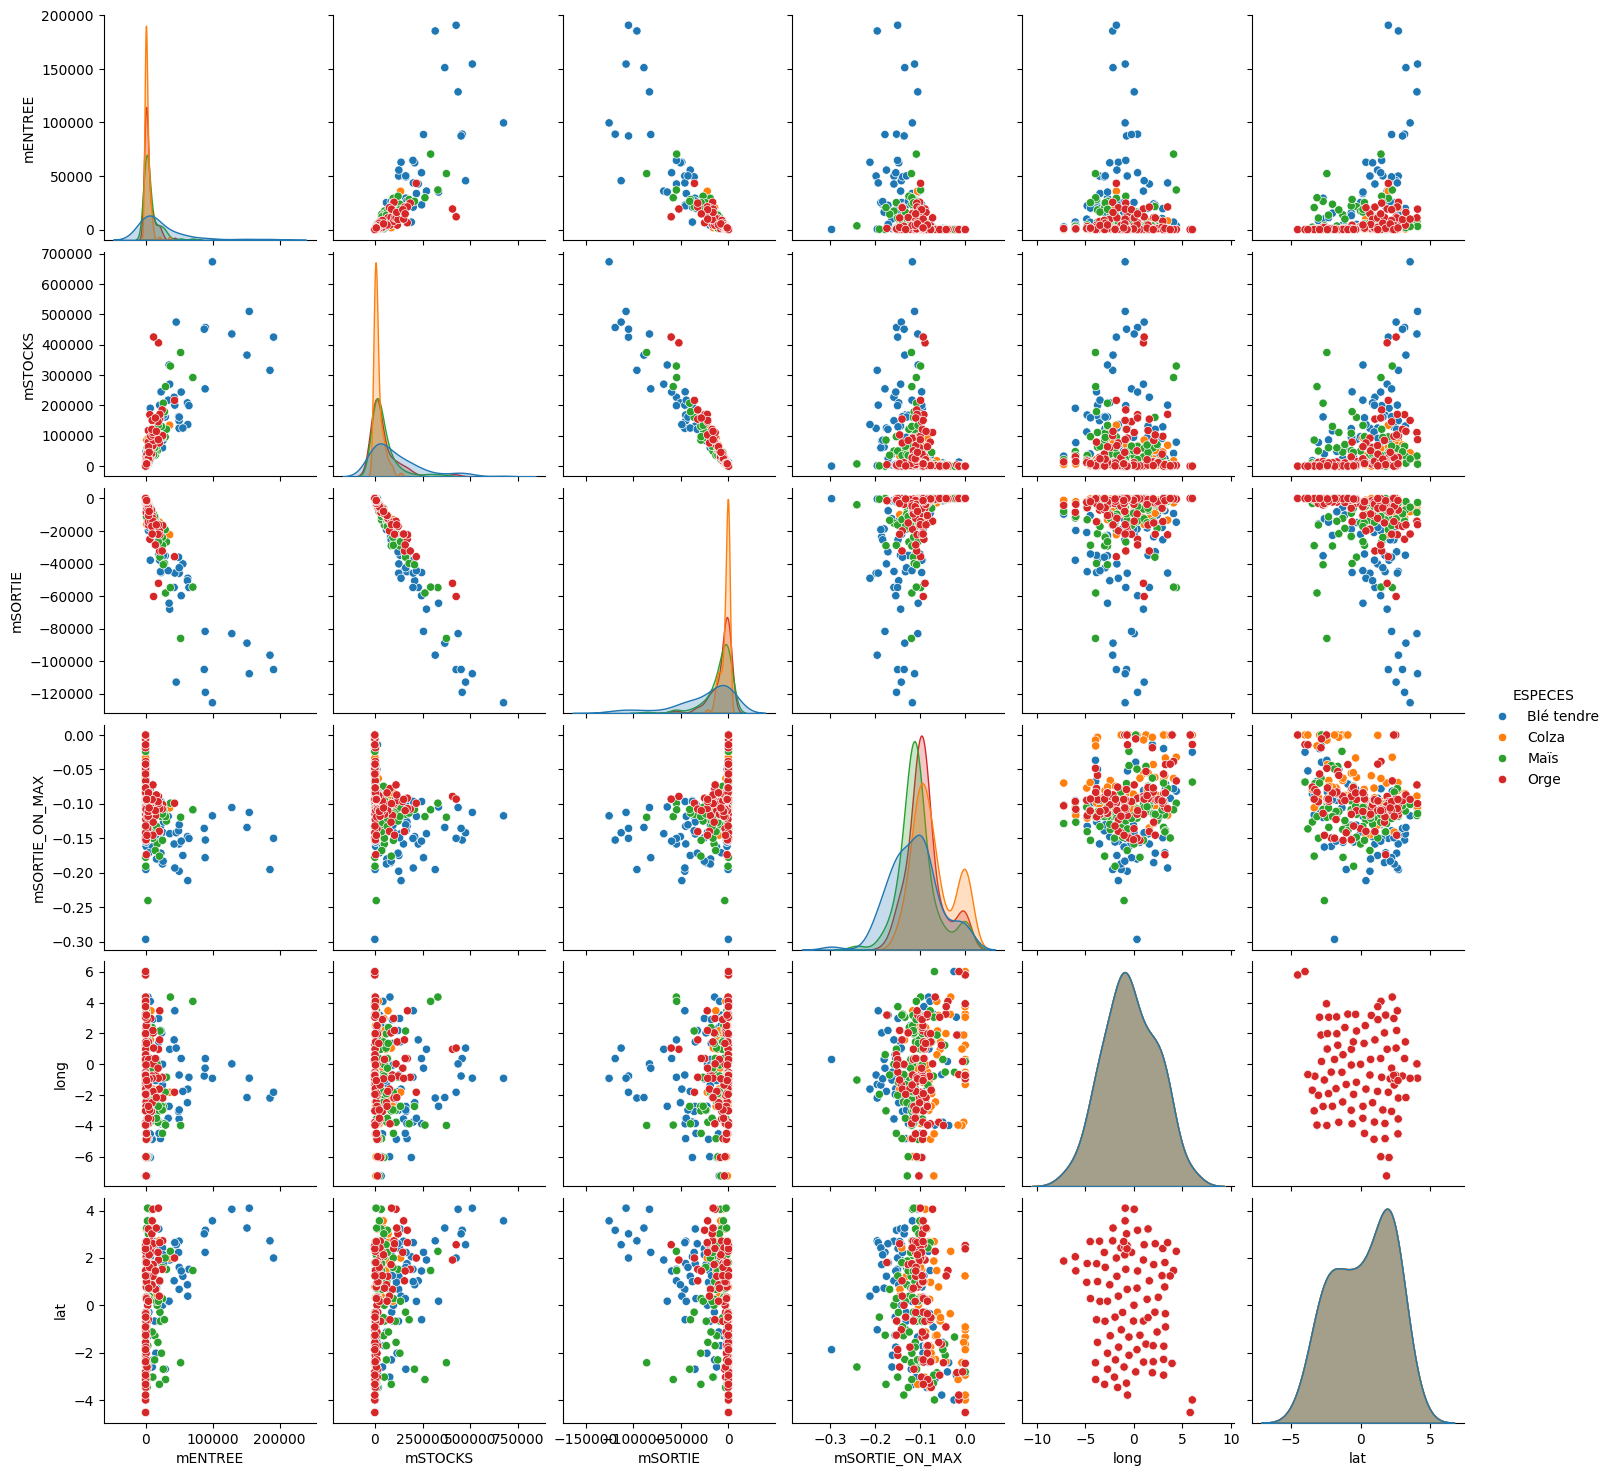

In [7]:
sns.pairplot(X, hue = 'ESPECES')
plt.show()

In [8]:
# ------------------------------------------ #
# I.I - Méthode de représentation
# ------------------------------------------ #

# ------------------------------------------ #
# time-series matrix
ts_df = df.pivot(columns='DATE',index=['ESPECES','DEP'], values= 'SORTIE').copy().T

# set period index for sktime
ts_df.set_index(pd.PeriodIndex(ts_df.index, freq='M'),inplace=True)

# delete first values -> SORTIES is build on Stocks lag which is NA on first value leading to abnormal on first observation 
ts_df = ts_df.iloc[2:,]

print('ts_df shape is :',ts_df.shape)
print('X shape is :',X.shape)

UTts_shape = ts_df.shape[1] == X.shape[0]

#ts_df.reset_index().T.info(verbose=True,show_counts= True)

# ------------------------------------------ #
# null data
NbNull = (ts_df.shape[1] - ts_df.notnull().sum(axis=1))
TriggerNull = NbNull == 0
TriggerNull15 = (NbNull>0) & (NbNull< 15)

print(f'There is {sum(TriggerNull == False)} rows with null values')



ts_df shape is : (302, 384)
X shape is : (384, 8)
There is 0 rows with null values


In [9]:
sel_espece = ['Blé tendre', 'Colza', 'Maïs', 'Orge'][1]

# Make a multiindex
ts_df = (
    df[df['ESPECES'] == sel_espece]
    .set_index(["DEP", "DATE"])
    .sort_index()
    [["SORTIE"]]
)

#  delete first values -> SORTIES is build on Stocks lag which is NA on first value leading to abnormal on first observation 
ts_df[ts_df.index.get_level_values("DATE") > '2000-08-01']

# verify 
check_raise(ts_df, "pd-multiindex")


True

# Models

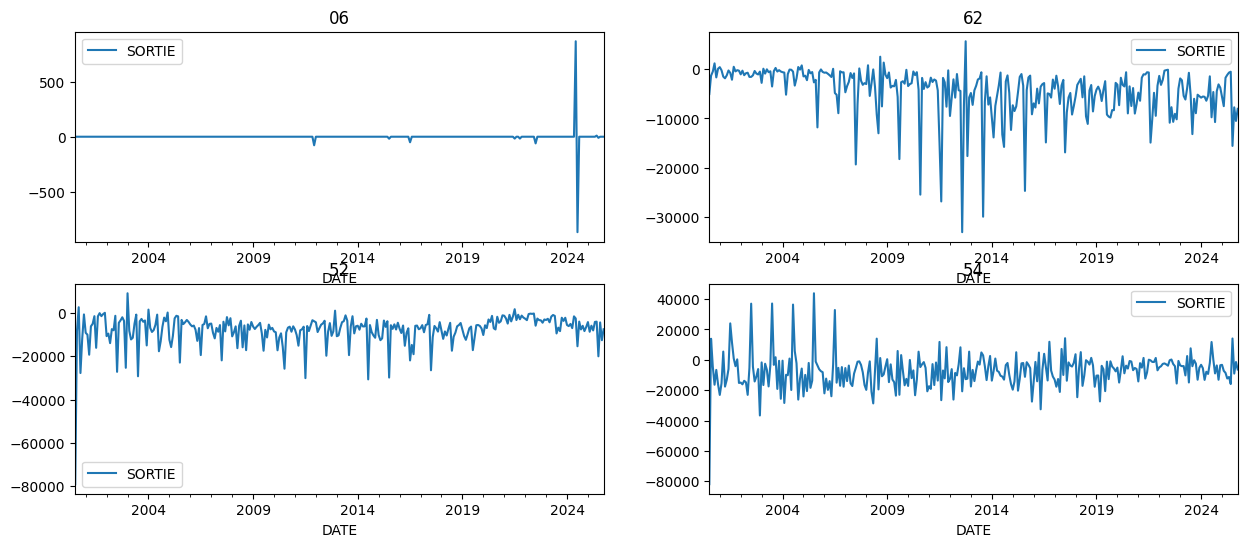

In [10]:
unique_DEP = ts_df.index.get_level_values('DEP').unique()
index_plot = unique_DEP[random.sample(range(len(unique_DEP)), k =4)]

fig, axes = plt.subplots(2,2, figsize = (15,6))
axes = axes.ravel()

for ii in range(4):
    ts_df.loc[index_plot[ii]].plot(ax=axes[ii])
    axes[ii].set_title(index_plot[ii])

plt.show()

Series are showing:
- Trend
- Non-null intercept
- Seasonality
- Outliers


In [22]:
X.iloc[:,1:].head()

,DEP,mENTREE,mSTOCKS,mSORTIE,mSORTIE_ON_MAX,long,lat
0,01,4888.35,88612.85,-14847.55,-0.088597,2.161115,-0.293865
1,02,89088.60,456799.45,-119078.85,-0.152503,0.372102,3.167391
2,03,25310.05,97358.70,-22072.10,-0.141314,0.000000,0.000000
3,04,60.05,2632.50,-481.95,-0.094942,3.057247,-2.287452
4,05,85.50,3716.10,-620.15,-0.094665,3.077914,-1.729593


In [ ]:
from sklearn.model_selection import train_test_split
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from sktime.datasets import load_arrow_head

k_means = KMeans(   )
k_means.fit(X)
plot_cluster_algorithm(k_means, X, k_means.n_clusters)

In [ ]:
from sklearn.model_selection import train_test_split
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
from sktime.datasets import load_arrow_head


k_means = TimeSeriesKMeans(n_clusters=8, init_algorithm="forgy", metric="dtw")
k_means.fit(ts_df)
plot_cluster_algorithm(k_means, ts_df, k_means.n_clusters)



In [29]:

#k_means = TimeSeriesKMeans( init_algorithm="forgy", metric="dtw",   n_clusters=8)
k_means = KMeans()

k_means.fit(X)

predict = k_means.predict(X)

clust_summary = pd.DataFrame({'clust':np.unique(predict),'num':None})

for ii in np.unique(predict):
    #print(ii, np.sum(predict == ii))
    clust_summary.loc[ii,'num'] = np.sum(predict == ii)

clust_summary.sort_values('num')

ValueError: could not convert string to float: 'Blé tendre'

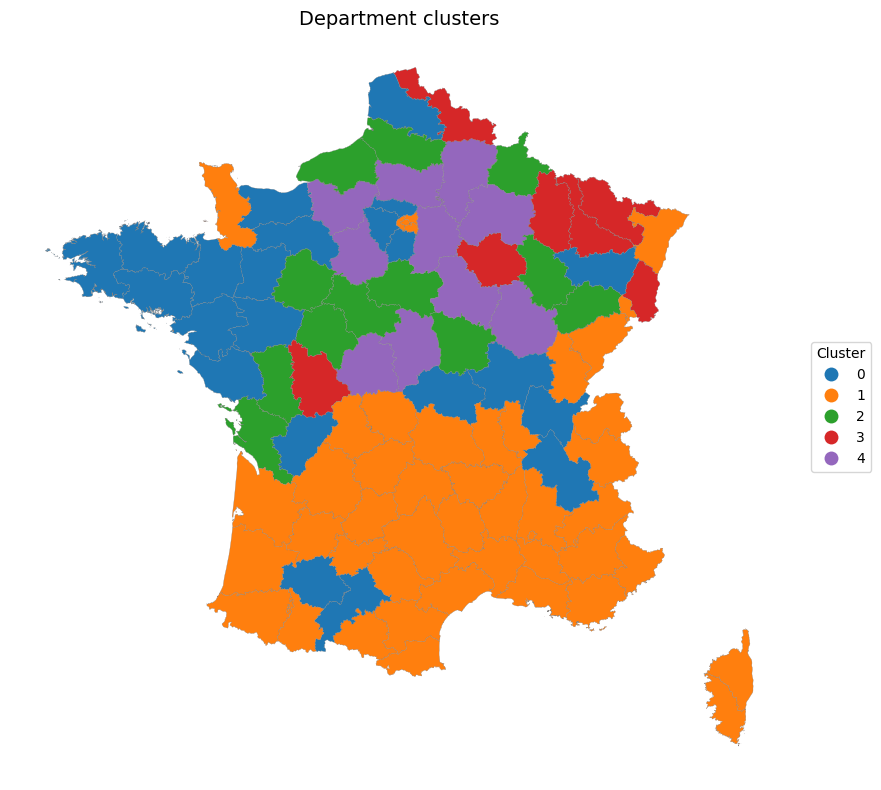

In [ ]:
gdf = gpd.GeoDataFrame({'cluster':predict}, geometry = fam.geom_data.geometry)

# Ensure cluster is categorical with 7 categories
gdf['cluster'] = gdf['cluster'].astype('category')

# Create a categorical colormap with 7 distinct colors
cmap = plt.get_cmap('tab10')  # has at least 10 distinct colors
colors = [cmap(i) for i in range(len(np.unique(predict)))]
cat_cmap = mcolors.ListedColormap(colors)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='cluster',
         categorical=True,
         cmap=cat_cmap,
         linewidth=0.2,
         edgecolor='gray',
         ax=ax,
         legend=True,
         legend_kwds={
             'title': 'Cluster',
             'loc': 'center left',
             'bbox_to_anchor': (1.02, 0.5)
         })

ax.set_title('Department clusters', fontsize=14)
ax.set_axis_off()  # remove axes

plt.tight_layout()
plt.show()